In [1]:
#import all the dependencies
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import  matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog

In [3]:
from scipy.ndimage.measurements import label
from sklearn.metrics import roc_auc_score, accuracy_score

In [4]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance

In [5]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [6]:
import pickle
import time
import glob

In [66]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [8]:
%matplotlib inline
# Libaries for video 
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math

In [9]:
#Lets read the data now

In [10]:
cars = glob.glob('vehicles/**/*.png')

In [11]:
not_a_car = glob.glob('non-vehicles/**/*.png')

In [12]:
#explore the dataset
def explore_data(file):
    print ('samples present are {} with shape : {}'.format(len(file),mpimg.imread(file[0]).shape))

In [13]:
print ('For cars datset')
explore_data(cars)
print ('For not_a_cars datset')
explore_data(not_a_car)

For cars datset
samples present are 8792 with shape : (64, 64, 3)
For not_a_cars datset
samples present are 8968 with shape : (64, 64, 3)


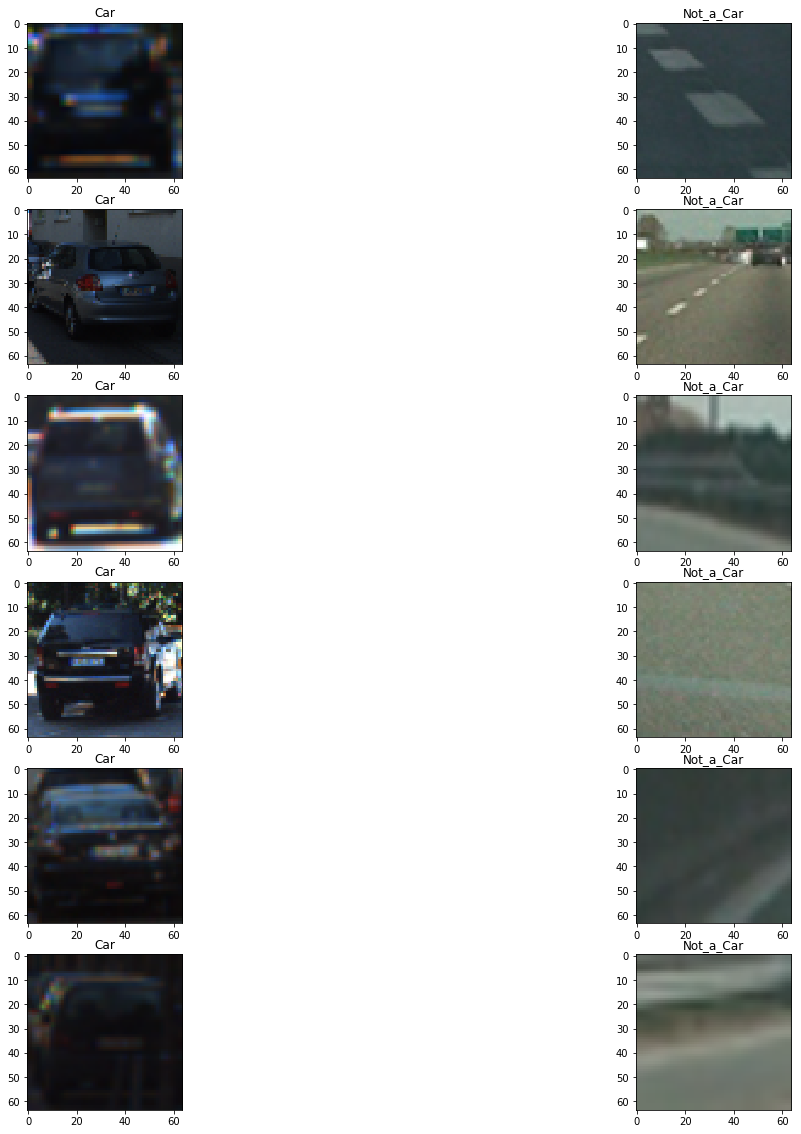

In [14]:
#plot the images....
plt.figure(figsize=(20,20))
cnt = 1
for i in range(0,3000,500):
    plt.subplot(6,2,cnt)
    plt.title('Car')
    plt.imshow(mpimg.imread(cars[i]))
    cnt+= 1
    plt.subplot(6,2,cnt)
    plt.title('Not_a_Car')
    (plt.imshow(mpimg.imread(not_a_car[i])))
    cnt+= 1

In [15]:
#Now letes try to extract eh features
def get_spatial_features(img,size=(64,64)):
    img = change_feature_space(img)
    img = cv2.resize(img,size)
    feature = img.ravel()
    return feature

In [16]:
def change_feature_space(img,space = cv2.COLOR_RGB2HSV):
    return cv2.cvtColor(img,space)

In [17]:
def display_images(img1,img2,title1 = None , title2 = None):
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.title(title1)
    plt.imshow(img1)
    plt.subplot(1,2,2)
    plt.title(title2)
    plt.imshow(img2)

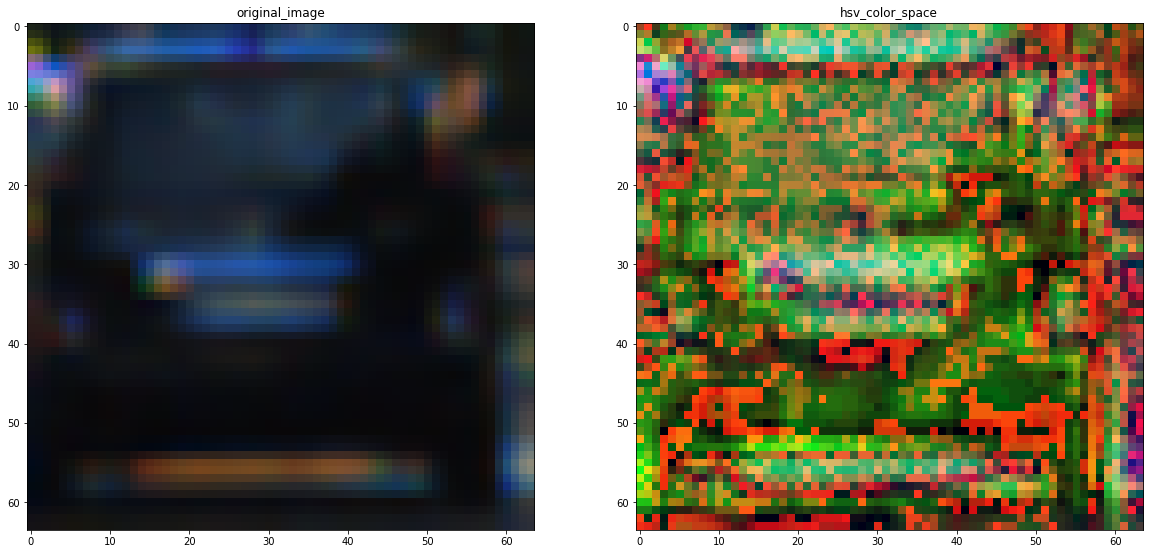

In [20]:
img = mpimg.imread(cars[0])
img_hsv  = change_feature_space(img)
display_images(img,img_hsv,'original_image','hsv_color_space')

In [71]:
#Now we get the Histogram features
def get_histogram_features(img):
    n_bins = 8
    bin_range =(0,255)
    c1 = np.histogram(img[:,:,0],bins = n_bins ,range = bin_range) 
    c2 = np.histogram(img[:,:,1],bins = n_bins ,range = bin_range) 
    c3 = np.histogram(img[:,:,2],bins = n_bins ,range = bin_range) 
    img  = change_feature_space(img)
    d1 = np.histogram(img[:,:,0],bins = n_bins ,range = bin_range) 
    d2 = np.histogram(img[:,:,1],bins = n_bins ,range = bin_range) 
    d3 = np.histogram(img[:,:,2],bins = n_bins ,range = bin_range) 
    return np.concatenate((c1[0],c2[0],c3[0],d1[0],d2[0],d3[0]))

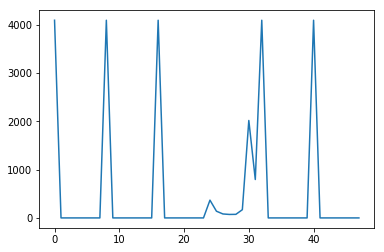

In [22]:
plt.plot(get_histogram_features(img))

In [23]:
#Now lets get HOG features:ue
def get_hog_features(img):
#     @features
    orient = 8
    pix_cell = 12
    cell_block = 2
    gr_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    feature = hog(gr_img, orientations= orient , pixels_per_cell= (pix_cell,pix_cell) , cells_per_block= (cell_block,cell_block))
    return feature

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


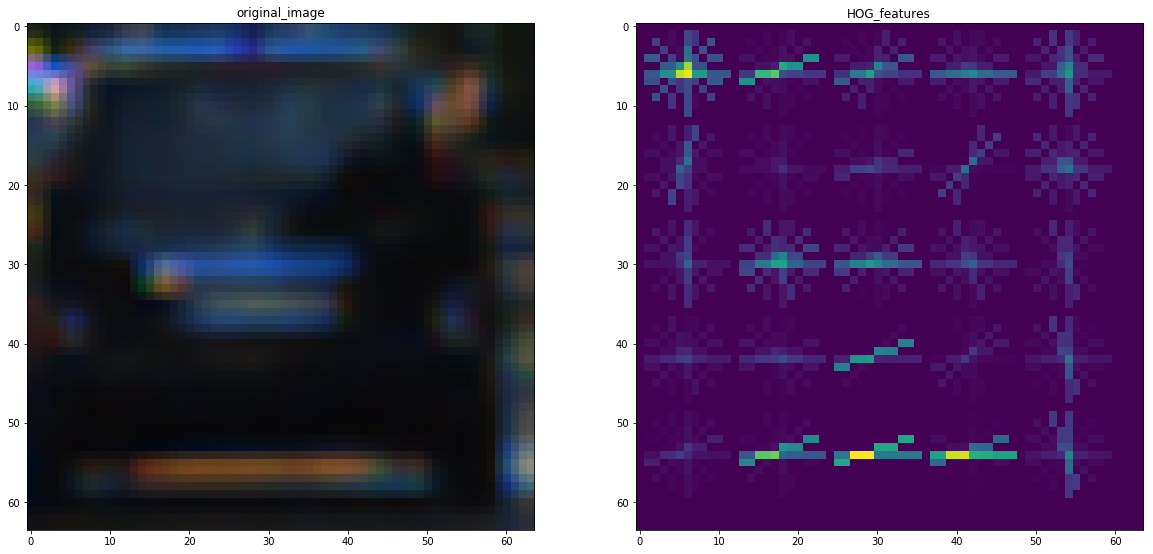

In [24]:
#lets visualize the hog image
gr_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# plt.imshow(gr_img)
feature, img_hog = hog(gr_img, orientations= 8  , pixels_per_cell= (12,12) , cells_per_block= (2,2) , visualise= True)
display_images(img,img_hog,'original_image','HOG_features')

In [25]:
#Now lets extract all the features
def get_all_the_features(img):
    sp = 8 
    feature_1 = get_spatial_features(img,(sp,sp))     
    feature_2 = get_histogram_features(img)
    feature_3 = get_hog_features(img)
    return np.concatenate((feature_1,feature_2,feature_3))                                    

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


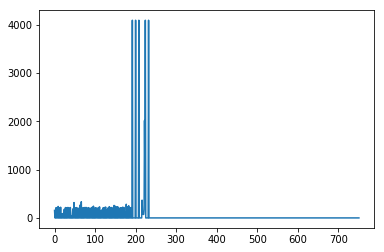

In [26]:
plt.plot(get_all_the_features(img))

In [27]:
def extract_features(img_paths):
    features = []
    for file in img_paths:
        image  = mpimg.imread(file)
        image  = np.uint8(image*255) # convert to 255
        feat = get_all_the_features(image)
        features.append(feat)
    return features 

In [28]:
car_features    =  extract_features(cars)
notcar_features = extract_features(not_a_car)
total_features = np.vstack((car_features, notcar_features)).astype(np.float32)   

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [29]:
print("Total Features are : ",total_features.shape)

Total Features are :  (17760, 752)


In [30]:
X_scaler = StandardScaler().fit(total_features)
scaled_features = X_scaler.transform(total_features)

In [31]:
#labels: cars : 1, not_a_car : 0
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [32]:
X_train,X_test,y_train,y_test  = train_test_split(scaled_features,y, test_size = 0.2)

In [33]:
print('Training set: X : ', X_train.shape , ' y: ', y_train.shape)
print('Testing  set: X : ', X_test.shape , '  y: ', y_test.shape)

Training set: X :  (14208, 752)  y:  (14208,)
Testing  set: X :  (3552, 752)   y:  (3552,)


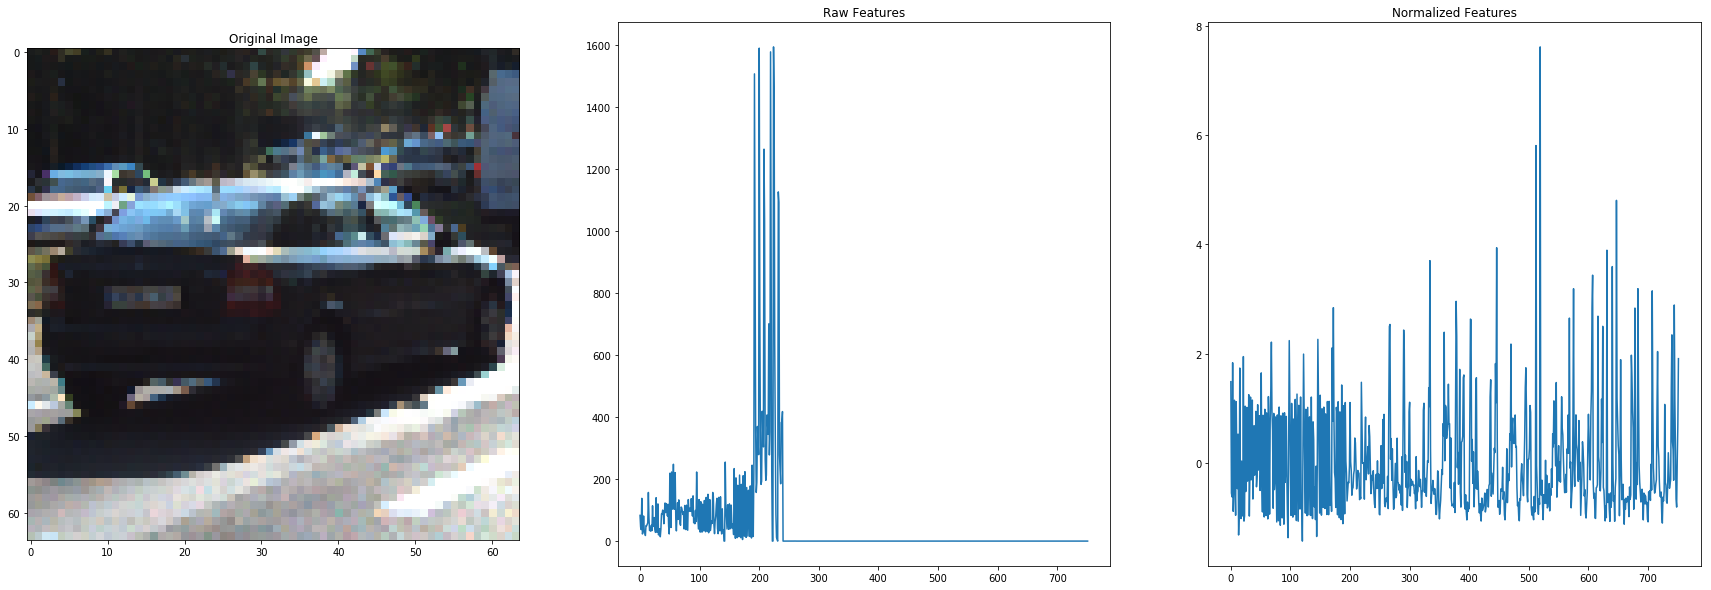

In [34]:
fig = plt.figure(figsize=(30,10))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[10]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(total_features[10])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(X_train[10])
plt.title('Normalized Features')

In [35]:
#Now lets train a classifier
classifier = LinearSVC()

In [36]:
def train_the_classifier(classifier,data):
    X_train, y_train , X_test, y_test = data
    classifier.fit(X_train,y_train)
    accuracy  =  accuracy_score(y_test,classifier.predict(X_test))
    print (' The testing accuracy is  : ', accuracy)
    return classifier

In [37]:
data = X_train, y_train , X_test, y_test
clf = train_the_classifier(classifier,data)

 The testing accuracy is  :  0.981981981982


In [67]:
classifier = RandomForestClassifier(n_estimators=100, max_features = 2,min_samples_leaf = 4,max_depth = 25)
clf = train_the_classifier(classifier , data)

 The testing accuracy is  :  0.989301801802


In [38]:
#Good now lets get the testing images
test_images = glob.glob('test_images/*.jpg')
test_img = []
for img in test_images:
    test_img.append(mpimg.imread(img))

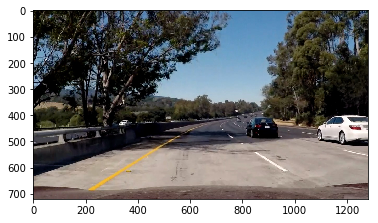

In [39]:
#Now lets plot one test image
plt.imshow(test_img[0])

In [40]:
#Now we have t put the sliding windows over it.....
#Ref: Udacity Lectures 
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    return draw_img

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    
    return window_list

In [41]:
x_min =[300, 1280]
y_min =[400, 530]
xy_min = (80, 80)

x_max =[300, 1280]
y_max =[400, 700]
xy_max = (160, 160)

n = 4 
x = []
y = []
xy =[]
for i in range(n):
    x_start_stop =[int(x_min[0] + i*(x_max[0]-x_min[0])/(n-1)), 
                   int(x_min[1] + i*(x_max[1]-x_min[1])/(n-1))]
    y_start_stop =[int(y_min[0] + i*(y_max[0]-y_min[0])/(n-1)), 
                   int(y_min[1] + i*(y_max[1]-y_min[1])/(n-1))]
    xy_window    =[int(xy_min[0] + i*(xy_max[0]-xy_min[0])/(n-1)), 
                   int(xy_min[1] + i*(xy_max[1]-xy_min[1])/(n-1))]
    x.append(x_start_stop)
    y.append(y_start_stop)
    xy.append(xy_window) 

Total number of windows: 128


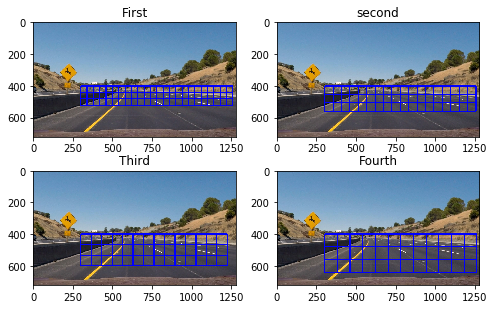

In [42]:
# visualize different window size
img1 = test_img[2]
windows1 = slide_window(img1, x_start_stop= x[0], y_start_stop = y[0], xy_window= xy[0], xy_overlap=(0.5, 0.5))
windows2 = slide_window(img1, x_start_stop= x[1], y_start_stop = y[1], xy_window= xy[1], xy_overlap=(0.5, 0.5))
windows3 = slide_window(img1, x_start_stop= x[2], y_start_stop = y[2], xy_window= xy[2], xy_overlap=(0.5, 0.5))
windows4 = slide_window(img1, x_start_stop= x[3], y_start_stop = y[3], xy_window= xy[3], xy_overlap=(0.5, 0.5))

window_img1 = draw_boxes(img1, windows1, color=(0, 0, 255), thick=6)
window_img2 = draw_boxes(img1, windows2, color=(0, 0, 255), thick=6)                    
window_img3 = draw_boxes(img1, windows3, color=(0, 0, 255), thick=6)
window_img4 = draw_boxes(img1, windows4, color=(0, 0, 255), thick=6)

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(8,5))

ax1.imshow(window_img1)
ax1.set_title('First')
ax2.imshow(window_img2)
ax2.set_title('second')
ax3.imshow(window_img3)
ax3.set_title('Third')
ax4.imshow(window_img4)
ax4.set_title('Fourth')
windows_all = list(windows1 + windows2 + windows3 + windows4)
print('Total number of windows:',len(windows_all))

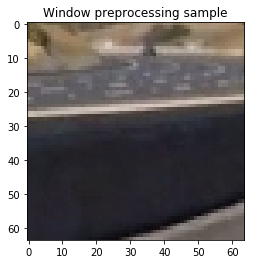

In [43]:
def preprocess_windows(img,window):
    img = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    img_resized = cv2.resize(img, (64, 64))  #resized according to the training data
    return img_resized
# test if the function works
img = preprocess_windows(img1,windows2[0])
plt.imshow(img)
plt.title('Window preprocessing sample')

In [44]:
def features_from_img(img,windows):
    features_all = []    
    for i in range(len(windows)):
        image = preprocess_windows(img,windows[i])
#         print(windows[i])
        features = get_all_the_features(image)
        features_all.append(features)       
    scaled_features = X_scaler.transform(features_all)
    return scaled_features

In [45]:
# Now lets Test the funcion
img_f = features_from_img(test_img[0],windows_all)
pred = clf.predict(img_f)
print (np.unique(pred,return_counts= True))

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(array([ 0.,  1.]), array([119,   9]))


In [46]:
def get_car_windows(prediction):
    windows_car = []
    for i in range(len(prediction)):
        if prediction[i] > 0.5: 
            windows_car.append(windows_all[i])
    return windows_car

[((1140, 400), (1220, 480)), ((1140, 440), (1220, 520)), ((1180, 440), (1260, 520)), ((830, 400), (936, 506)), ((1095, 400), (1201, 506)), ((1148, 400), (1254, 506)), ((1092, 400), (1225, 533)), ((620, 400), (780, 560)), ((1100, 400), (1260, 560))]


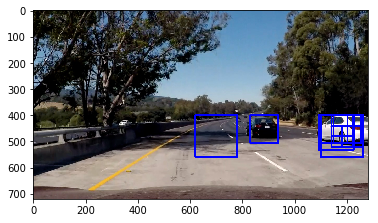

In [68]:
windows_car = get_car_windows(pred)
img_box = draw_boxes(test_img[0], windows_car, color=(0, 0, 255), thick=6)
plt.imshow(img_box)
print (windows_car)

In [48]:
def find_cars(img):
    img_features = features_from_img(img,windows_all)
    pred = clf.predict(img_features)
    windows_car = get_car_windows(pred)
    return windows_car

In [72]:
test_output = [] 
for i in range(len(test_img)):
    windows_car = find_cars(test_img[i])
#     print (windows_car)
    test_output.append(draw_boxes(test_img[i], windows_car, color=(0, 0, 255), thick=6))

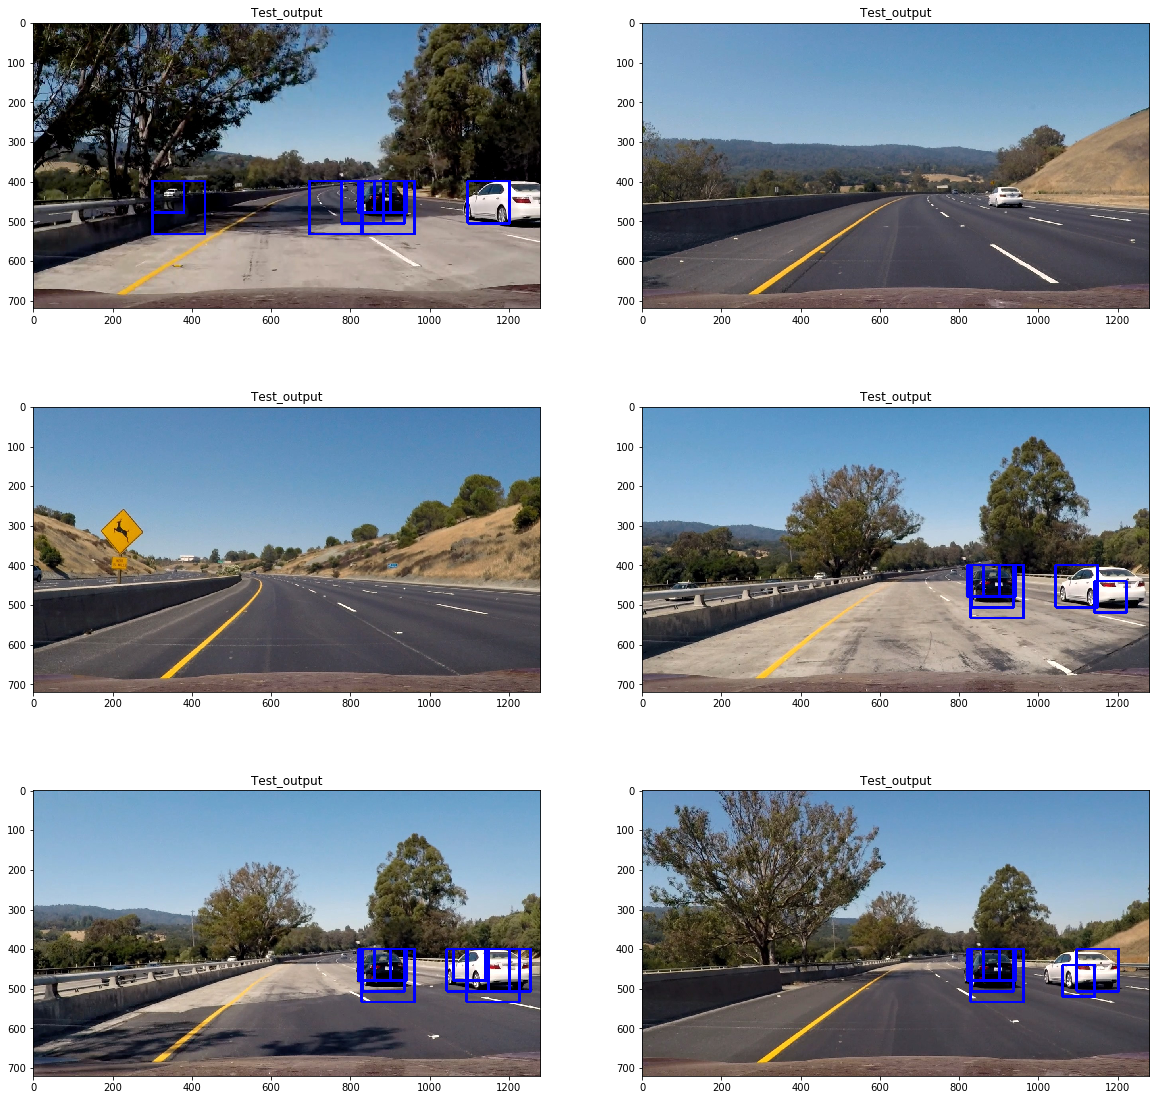

In [73]:
#plot the images....
plt.figure(figsize=(20,20))
for i in range(len(test_images)):
    plt.subplot(3,2,i+1)
    plt.title('Test_output')
    plt.imshow(test_output[i])

In [51]:
#Now lets add the heat baby
#ref : Udacity
# create a heat map
def add_heat(heatmap, boxlist):
    # Iterate through list of bboxes    
    for box in boxlist:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

In [52]:
# truncate value exeed upper limit
def apply_threshold(heatmap, upper = None , lower  = None ):
    if (upper != None):
        heatmap[heatmap > upper] = 1
    if (lower != None):    
        heatmap[heatmap < lower] = 0
    return heatmap

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


2 cars found


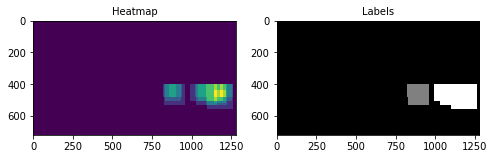

In [53]:
image = test_img[3]
bboxes = find_cars(image)
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heat, bboxes)
labels = label(heatmap)
print(labels[1], 'cars found')
f, (ax1, ax2)= plt.subplots(1, 2, figsize=(8,8))
ax1.imshow(heatmap)
ax1.set_title('Heatmap', fontsize=10)
ax2.imshow(labels[0], cmap='gray')
ax2.set_title('Labels', fontsize=10)

In [54]:
#Now lets define the bounding boxes 
def find_labeled_boxes(img, labels):
    img_copy = np.copy(img)
    bboxes = []
    for car in range(1, labels[1]+1):
        nonzero = (labels[0] == car).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    return bboxes

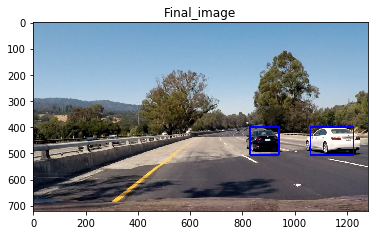

In [95]:
test_image_final = []
for i in range(len(test_img)):
    image = test_img[i]
    boxes = find_cars(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, boxes)
    heatmap = apply_threshold(heatmap,upper =10 ,  lower  = 2)
    labels = label(heatmap)
    bboxes = find_labeled_boxes(image, labels)
    img_box = draw_boxes(image, bboxes, color=(0, 0, 255), thick=6)
#     plt.imshow(img_box)
#     plt.title('Testing of BBox')
    test_image_final.append(img_box)

plt.imshow(test_image_final[4])
plt.title('Final_image')
#plot the images....
# plt.figure(figsize=(20,20))
# for i in range(len(test_image_final)):
#     plt.subplot(3,2,i+1)
#     plt.title('Test_Final_output')
#     plt.imshow(test_image_final[i])

In [56]:
#good job
#now lets track the car
class car():
    def __init__(self):
        self.average_centroid= (0,0)
        self.width = 0
        self.height = 0 
        self.detected = 0.5 

In [57]:
def get_distance(x1,x2):
    return distance.euclidean(x1,x2)

In [58]:
def track_car(cent,old_Car):
    t_dist = 40 
    Dist = [] 
    if not old_Car: 
        car_found = False 
        car_id = 0
        return car_found,car_id
    else:
        for car in old_Car:
            dist = get_distance(cent, car.average_centroid)
            Dist.append(dist)
        car_id = np.argmin(Dist)
        if Dist[car_id] < t_dist:
            car_found = True
        else:
            car_found = False
        return car_found, car_id

In [59]:
def box_centroid_size(bboxes):
    box_centroids = []
    box_size = []    
    for box in bboxes:
        x = int((box[0][0] + box[1][0])/2)
        y = int((box[0][1] + box[1][1])/2)
        box_centroids.append((x,y))
        width =  int((box[1][0] - box[0][0])/2)
        height = int((box[1][1] - box[0][1])/2)
        box_size.append((width,height))
    return box_centroids, box_size

In [60]:
def car_box(Old_Cars, detected_threshold = 0.51):
    new_box = []
    for new_car in Old_Cars:
        if new_car.detected > detected_threshold:
            offset = new_car.average_centroid          
            width = new_car.width
            height = new_car.height
            bbox0 = (int(-width+offset[0]),
                     int(-height+offset[1]))
            bbox1 = (int(width+offset[0]),
                     int(height+offset[1]))
            new_box.append((bbox0,bbox1))
    return new_box

In [89]:
def process_img(image):
    class car():
        def __init__(self):
            self.average_centroid= (0,0)
            self.width = 0
            self.height = 0 
            self.detected = 0.5    
    global Detected_Cars
    global heatmap
    
    draw_img = np.copy(image)
    boxes = find_cars(image)
    draw_img = draw_boxes(draw_img, boxes, color=(0, 0, 255), thick=2)
    heatmap_new = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap_new = add_heat(heatmap_new, boxes)
    heatmap_new = apply_threshold(heatmap_new,upper  = 1)
    heatmap = 0.9*heatmap + 0.1*heatmap_new

    wrap_img = np.zeros_like(image) 
    wrap_img[:,:,1] = heatmap[:]*250 
    draw_img = cv2.addWeighted(draw_img, 1, wrap_img, 0.5, 0)

    heatmap_sure = np.copy(heatmap)
    heatmap_sure = apply_threshold(heatmap_sure, lower = 0.85)
    labels = label(heatmap_sure)
    bounding_boxes = find_labeled_boxes(image, labels)
    centroids,box_size = box_centroid_size(bounding_boxes)
    New_Cars = [] 
    for n in range(len(centroids)):
        car_found, k = track_car(centroids[n],Detected_Cars) 
        if car_found  == True:
            Detected_Cars[k].average_centroid = (int(0.9*Detected_Cars[k].average_centroid[0] + 0.1*centroids[n][0]),int(0.9*Detected_Cars[k].average_centroid[1] + 0.1*centroids[n][1]))         
            Detected_Cars[k].width =   math.ceil(0.9*Detected_Cars[k].width + 0.1*box_size[n][0])
            Detected_Cars[k].height =  math.ceil(0.9*Detected_Cars[k].height + 0.1*box_size[n][1])
            Detected_Cars[k].detected = Detected_Cars[k].detected + 0.2
        else: 
            new_car = car()
            new_car.average_centroid = centroids[n]
            new_car.width =  box_size[n][0]
            new_car.height = box_size[n][1]            
            New_Cars.append(new_car)
            
    Detected_Cars_old = list(Detected_Cars) 
    Detected_Cars = New_Cars[:] 
    if Detected_Cars_old:
        for car in Detected_Cars_old:
            if car.detected > 0.17: 
                Detected_Cars.append(car)
    car_boxes = car_box(Detected_Cars, detected_threshold = 0.55)
    draw_img = draw_boxes(draw_img, car_boxes, color=(255, 0, 0), thick=5)                     
    for car in Detected_Cars:
        car.detected = car.detected*0.8    
    return draw_img

In [82]:
global Detected_Cars
global heatmap

heatmap = np.zeros_like(img1[:,:,0]).astype(np.float) 
Detected_Cars = []

# output video directory
video_output = 'test_output.mp4'
# input video directory
clip1 = VideoFileClip("test_video.mp4")
# video process pipline
video_clip = clip1.fl_image(process_img) 
# write processed files
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|█████████▋| 38/39 [00:13<00:00,  3.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 13.5 s, sys: 91.2 ms, total: 13.5 s
Wall time: 15.5 s


In [90]:
global Detected_Cars
global heatmap
heatmap = np.zeros_like(img1[:,:,0]).astype(np.float) 
Detected_Cars = []

# output video directory
video_output = 'output_project.mp4'
# input video directory
clip1 = VideoFileClip("project_video.mp4")
# video process pipline
video_clip = clip1.fl_image(process_img) 
# write processed files
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_project.mp4
[MoviePy] Writing video output_project.mp4


100%|█████████▉| 1260/1261 [07:18<00:00,  2.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project.mp4 

CPU times: user 7min 12s, sys: 2.52 s, total: 7min 14s
Wall time: 7min 20s
